In [2]:
from _util import *
import _discrete as discrete
import _analyze as analyze
reload(discrete)

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

################################################
data_existed = 1
gamma = 0.95 # 0.99
pi1 = pi = discrete.toy_pi()
################################################
if not data_existed:
    N = 10000
    T = 200 #1000
    
    simu_circle = discrete.simuCricle(gamma = gamma, pi = pi) 
    trajs_behav, details_behav = simu_circle.simu_trajs(N, T, policy = "behav")
    trajs_tp, details_tp = simu_circle.simu_trajs(N, T, policy = "tp")

    ################################################
    omega = simu_circle.get_omega(details_behav, details_tp)
    V_true, V_true_std = simu_circle.get_V(details_tp[2])

    printR("true_V = {:.3f} with std = {:.3f}".format(V_true, V_true_std))
    ################################################
    omega_star = []
    Q = np.zeros((3, 2))

    for S in [0, 1, 2]:
        omega_star_fixed_S = []
        for A in [-1, 1]:
            init_SA = [S, A]
            a = now()
            trajs_tp, details_tp = simu_circle.simu_trajs(N, T, policy = "tp", init_SA = init_SA)
            omega = simu_circle.get_omega(details_behav, details_tp)
            omega_star_fixed_S.append(omega)
            Q[S, (A + 1) // 2], std_Q = simu_circle.get_V(details_tp[2])
            print(S, A, "DONE! with mean = {:.3f} and std = {:.3f}".format(Q[S, (A + 1) // 2], std_Q))
        omega_star.append(omega_star_fixed_S)
    omega_star = np.array(omega_star)
    toy_data = {"V_true" : V_true
               , "Q" : Q
               , "omega" : omega
               , "omega_star" : omega_star}
    # dump(toy_data, "toy_data")
else:
    toy_data = load("res/toy_data_095")
#     toy_data = load("res/toy_data")
    V_true = toy_data["V_true"]
    Q = toy_data["Q"]
    omega = toy_data["omega"]
    omega_star = toy_data["omega_star"]


## Estimation for Triply-robust

In [90]:
seed = 0
print("\n", "seed = ", seed, "\n")
np.random.seed(seed)
init_size = 2000
rep = 200
n_gpu = rep
T = 50
incomplete_ratio = 20
np.random.seed(seed)

settings = [[1, 1, 0], [1, 0, 1], [0, 1, 1]]

################################################
Q_ratio =  2
omega_ratio = 10 #25
omega_star_ratio = 25


Q_error = Q + randn(3, 2) / Q_ratio

omega_error = omega + randn(3, 2) / omega_ratio 
omega_error /= np.mean(omega_error)
omega_star_error = omega_star.copy()
for s in range(3):
    for a in range(2):
        omega_star_error[s][a] = omega_star[s][a] + randn(3, 2) / omega_star_ratio
        omega_star_error[s][a] /= np.mean(omega_star_error[s][a])

omega_error = np.clip(omega_error, 0, None) 
omega_star_error = np.clip(omega_star_error, 0, None) 
   
################################################     
res_all = []
N_range = [10, 20, 30, 40, 50]
for setting in settings:
    printR(setting)
    res_this = []
    for N in N_range:
        printR("N = {}".format(N))
        ###############################################
        Q_used = Q.copy()
        omega_used = omega.copy()
        omega_star_used = omega_star.copy()
        ###############################################
        if setting[0]:
            Q_used = Q_error.copy()
        if setting[1]:
            omega_used = omega_error.copy()
        if setting[2]:
            omega_star_used = omega_star_error.copy()
        
        ####################################################################################
        true_Q = discrete.TrueQ(Q_used)
        true_omega = discrete.TrueOmega(omega_used)
        true_omega_star = discrete.TrueOmega_star(omega_star_used)

        ray.shutdown()
        simu_circle = discrete.simuCricle(gamma = gamma, pi = pi) 

        a = now()
        rec = analyze.recorder()

        for i in range(rep // n_gpu):
            @ray.remote # num_cpus=1 # ()
            def one_seed1(seed):
                reload(discrete)
                os.environ["OMP_NUM_THREADS"] = "1"
                os.environ["MKL_NUM_THREADS"] = "1"
                os.environ["OPENBLAS_NUM_THREADS"] = "1"
                os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
                os.environ["NUMEXPR_NUM_THREADS"] = "1"

                trajs_train, _ = simu_circle.simu_trajs(N, T, policy = "behav", seed = seed)
                gpu_idx = 0
                # ############################ TRIPLE to estimate values ############################
                are = discrete.ARE_discrete(trajs_train, pi = pi1, gamma = gamma, gpu_number = gpu_idx, incomplete_ratio = incomplete_ratio, L = 2
                                , sepe_A = True)
                init_S = np.random.choice(a = 3, size = init_size, p = [1 / 3, 1 / 3, 1 / 3])
                are.init_S = init_S 
                are.load_true(true_Q, true_omega, true_omega_star)
                are.est_double_robust()
                are.est_triply_robust()  
                are.est_quad_robust()
                #######
                return [are.raw_Qs, are.DR_V, are.TR_V, are.QR_V]
            ray.init()
            ###########
            futures = [one_seed1.remote(j) for j in range(n_gpu * i, n_gpu * (i + 1))]
            res = ray.get(futures)
            for j in range(n_gpu):
                rec.update(V_true, are_details = res[j])
            rec.analyze()
            printR("time cost for {}-th rep = {:.1f} mins".format(i, (now() - a) / 60))
            ray.shutdown()
        res_this.append(rec)
    res_all.append(res_this)


 seed =  0 

[1, 1, 0]
N = 10


2020-12-10 01:41:51,931	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,1.083,0.893,0.835,1.033,0.960,0.875
TR,0.402,0.325,-0.161,0.406,0.945,0.895
QR,0.393,0.318,-0.155,0.402,0.955,0.870


Q: RMSE = 0.76, bias = 0.76
rep = 200
time cost for 0-th rep = 0.1 mins
N = 20


2020-12-10 01:41:58,061	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.642,0.553,0.340,0.727,0.995,0.975
TR,0.358,0.295,-0.199,0.296,0.885,0.835
QR,0.348,0.287,-0.197,0.287,0.905,0.820


Q: RMSE = 0.76, bias = 0.76
rep = 200
time cost for 0-th rep = 0.1 mins
N = 30


2020-12-10 01:42:04,410	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.548,0.466,0.320,0.593,0.985,0.955
TR,0.318,0.259,-0.221,0.242,0.855,0.815
QR,0.305,0.251,-0.208,0.237,0.875,0.820


Q: RMSE = 0.76, bias = 0.76
rep = 200
time cost for 0-th rep = 0.1 mins
N = 40


2020-12-10 01:42:10,511	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.519,0.449,0.345,0.514,0.985,0.92
TR,0.223,0.181,-0.102,0.210,0.950,0.89
QR,0.220,0.176,-0.097,0.206,0.940,0.87


Q: RMSE = 0.76, bias = 0.76
rep = 200
time cost for 0-th rep = 0.1 mins
N = 50


2020-12-10 01:42:17,898	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.512,0.431,0.348,0.460,0.950,0.855
TR,0.175,0.137,-0.088,0.188,0.945,0.910
QR,0.175,0.139,-0.086,0.184,0.950,0.910


Q: RMSE = 0.76, bias = 0.76
rep = 200
time cost for 0-th rep = 0.1 mins
[1, 0, 1]
N = 10


2020-12-10 01:42:25,368	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,1.258,1.080,1.059,1.010,0.885,0.785
TR,0.913,0.792,-0.771,0.694,0.885,0.755
QR,0.393,0.306,0.081,0.520,0.985,0.955


Q: RMSE = 0.76, bias = 0.76
rep = 200
time cost for 0-th rep = 0.1 mins
N = 20


2020-12-10 01:42:31,540	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.773,0.685,0.555,0.711,0.960,0.900
TR,0.691,0.618,-0.610,0.484,0.850,0.675
QR,0.315,0.255,-0.059,0.351,0.975,0.945


Q: RMSE = 0.76, bias = 0.76
rep = 200
time cost for 0-th rep = 0.1 mins
N = 30


2020-12-10 01:42:37,721	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.701,0.611,0.542,0.580,0.945,0.825
TR,0.690,0.641,-0.640,0.390,0.705,0.505
QR,0.266,0.209,-0.043,0.286,0.955,0.915


Q: RMSE = 0.76, bias = 0.76
rep = 200
time cost for 0-th rep = 0.1 mins
N = 40


2020-12-10 01:42:43,922	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.683,0.602,0.565,0.503,0.885,0.725
TR,0.569,0.522,-0.517,0.338,0.715,0.555
QR,0.235,0.184,0.055,0.247,0.960,0.920


Q: RMSE = 0.76, bias = 0.76
rep = 200
time cost for 0-th rep = 0.1 mins
N = 50


2020-12-10 01:42:51,080	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.680,0.590,0.569,0.449,0.785,0.635
TR,0.565,0.525,-0.525,0.300,0.590,0.445
QR,0.203,0.160,0.068,0.220,0.970,0.930


Q: RMSE = 0.76, bias = 0.76
rep = 200
time cost for 0-th rep = 0.1 mins
[0, 1, 1]
N = 10


2020-12-10 01:42:58,263	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.177,0.140,0.017,0.180,0.950,0.910
TR,0.179,0.140,0.012,0.179,0.935,0.910
QR,0.180,0.142,0.011,0.179,0.930,0.905


Q: RMSE = 0.16, bias = 0.16
rep = 200
time cost for 0-th rep = 0.1 mins
N = 20


2020-12-10 01:43:04,553	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.122,0.096,0.020,0.130,0.955,0.920
TR,0.121,0.096,0.016,0.129,0.955,0.905
QR,0.121,0.096,0.015,0.129,0.955,0.920


Q: RMSE = 0.16, bias = 0.16
rep = 200
time cost for 0-th rep = 0.1 mins
N = 30


2020-12-10 01:43:11,092	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.106,0.083,0.007,0.108,0.955,0.915
TR,0.105,0.083,0.007,0.108,0.955,0.920
QR,0.106,0.084,0.009,0.108,0.955,0.925


Q: RMSE = 0.16, bias = 0.16
rep = 200
time cost for 0-th rep = 0.1 mins
N = 40


2020-12-10 01:43:17,503	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.095,0.074,0.005,0.094,0.94,0.885
TR,0.094,0.073,0.005,0.093,0.94,0.900
QR,0.095,0.074,0.007,0.094,0.94,0.895


Q: RMSE = 0.16, bias = 0.16
rep = 200
time cost for 0-th rep = 0.1 mins
N = 50


2020-12-10 01:43:24,114	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.085,0.068,0.002,0.084,0.965,0.900
TR,0.084,0.067,0.004,0.084,0.960,0.900
QR,0.086,0.068,0.006,0.084,0.955,0.895


Q: RMSE = 0.16, bias = 0.16
rep = 200
time cost for 0-th rep = 0.1 mins


## Plot for Triply-robust

In [6]:
# seed = 0
# print("\n", "seed = ", seed, "\n")
# np.random.seed(seed)
# init_S = np.random.choice(a = 3, size = 10000, p = [1 / 3, 1 / 3, 1 / 3])
# rep = 200
# n_gpu = rep
# T = 100
# incomplete_ratio = 20
# np.random.seed(seed)

# settings = [[1, 1, 0], [1, 0, 1], [0, 1, 1]]
N_range = [10, 20, 30, 40, 50]


In [7]:
res_settings = []
for i in range(3):
    mse_DR = [np.mean(arr(res_all[i][N].DR['error']) ** 2) for N in range(len(N_range))]
    mse_TR = [np.mean(arr(res_all[i][N].TR['error']) ** 2) for N in range(len(N_range))]
    mse_QR = [np.mean(arr(res_all[i][N].QR['error']) ** 2) for N in range(len(N_range))]
    rr = arr([mse_DR, mse_TR, mse_QR])
    rr = np.sqrt(rr)
    res_settings.append(rr)

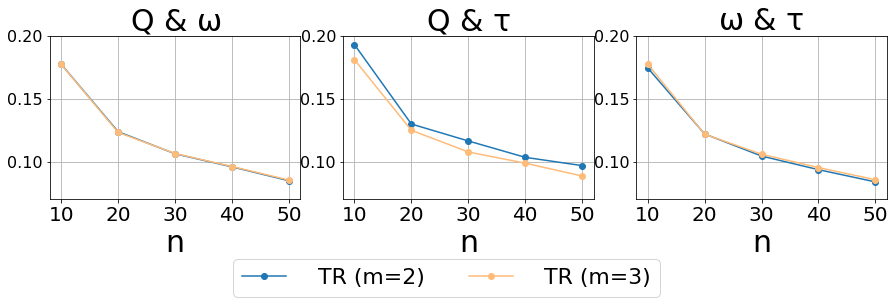

In [37]:
from _util import *
import _plot as plot
reload(plot)
marker = "o"
############################################

fig, axs = plt.subplots(1, 3,figsize=(15,3))
plt.subplots_adjust(wspace = .17)

labels = ["  TR (m=2)", "  TR (m=3)"]
# labels = ["  TR\n(m=2)", "  TR\n(m=3)"]
# labels = [r"$\widehat{V}_{TR}^{2}$", "$\widehat{V}_{TR}^{3}$"]
X_range = N_range#[1:] #[10, 20, 30, 40, 50]
setting_names = [r"Q & $\omega$", r"Q & $\tau$", r"$\omega$ & $\tau$"]
lows = [0.07, 0.07, 0.07]
highs = [0.2, 0.2, 0.2]
y_labes = [None, None, None] # "RMSE"
for s in range(3):
    RMSEs = res_settings[s]
    ax09, legends09 = plot.plot_curves(RMSEs[1:], horizontal = None, x_axis = X_range, title = setting_names[s]
                      , labels = ["TR", "QR"], legend_title = "method"
                      , y_low = lows[s]
                      , y_high = highs[s] #np.max(RMSEs[1:])
#                       , title_size = 22, x_label_size = 18, y_label_size = 18
                      , title_size = 30, x_label_size = 30, y_label_size = 26
                      , marker = marker
                      , xlabel = "n", y_lab = y_labes[s], path = None
                     , ax = axs[s], is_sub_plot = True, print_legend = False)
    ax09.tick_params(axis='x', which='major', labelsize=20)
    ax09.tick_params(axis='y', which='major', labelsize=16)

fig.legend(legends09,     # The line objects
       labels = labels,   # The labels for each line
        bbox_to_anchor = [0.7, -0.3] # location
    , ncol=2, numpoints=1
           , fontsize = 22
        # The bbox_to_anchor sets the bounding box in coordinates according to the bbox_transform.
        , bbox_transform = plot.BlendedGenericTransform(fig.transFigure, ax09.transAxes)
       )



fig.show()
fig.savefig("final_plot/plot/" + "toy_Triply.png", bbox_inches='tight')
